In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import tv_model, ResBam
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import LoadImage, AsTensor, Transpose
import cosmosis.dataset as dataset

from dataset import Ranzcr
from learning import RSelector

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

from IPython.display import display


In [ ]:
ds_params={'embed': [],
            'image_dir': './data/ranzcr/train',
            'target_csv': './data/ranzcr/train.csv',
            'target_type': 'ETT',
            'transform': transforms.Compose([LoadImage(),
                                             transforms.Resize(224),
                                             ]),
            'target_transform': None}

ds = Ranzcr(**ds_params)
ids = dataset.ImageDatasetStats()

for i in ds.ds_idx:
    ids(ds[i][0])
    
print(ids.stats.mean) #123.2/255=.483
print(ids.stats.stddev) #59.4/255=.233

CDataset created...
CDataset created...
CDataset created...
CModel loaded...
ResBam model loaded...
learning time: 0:00:45.156264
epoch: 0, lr: 0.005
train loss: 1.141705387876234, val loss: 0.8707543717963355
sk_train_log: 0.6172616922186502, sk_val_log: 0.5688711957080937
learning time: 0:01:30.224792
epoch: 1, lr: 0.005
train loss: 0.8431050522636822, val loss: 0.7093884285007205
sk_train_log: 0.652034077135425, sk_val_log: 0.7144551041652585
learning time: 0:02:15.489957
epoch: 2, lr: 0.005
train loss: 0.7314175842827513, val loss: 0.754144729248115
sk_train_log: 0.6374409377162185, sk_val_log: 0.6328518139340182
learning time: 0:03:00.888944
epoch: 3, lr: 0.005
train loss: 0.7037504458700428, val loss: 0.6393681008900914
sk_train_log: 0.6891316514346096, sk_val_log: 0.716953956102268
learning time: 0:03:46.282525
epoch: 4, lr: 0.005
train loss: 0.6566571879932899, val loss: 0.6544611624308995
sk_train_log: 0.7579437178332563, sk_val_log: 0.6507116073315463
learning time: 0:04:32.8

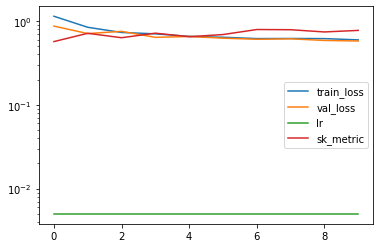

In [4]:
ds_params={'train_params': {'embed': [],
                            'image_dir': './data/ranzcr/train',
                            'target_csv': './data/ranzcr/train.csv',
                            'target_type': 'ETT',
                            'transform': transforms.Compose([LoadImage(),
                                                             transforms.Resize(1000),
                                                             transforms.RandomRotation(10),
                                                             transforms.CenterCrop(800),
                                                             transforms.RandomCrop(512),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(.483,.233),
                                                             ]),
                            'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'val_params': {'embed': [],
                          'image_dir': './data/ranzcr/train',
                          'target_csv': './data/ranzcr/train.csv',
                          'target_type': 'ETT',
                          'transform': transforms.Compose([LoadImage(),
                                                           transforms.Resize(1000),
                                                           transforms.CenterCrop(512),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(.483,.233),
                                                           ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'test_params': {'embed': [],
                           'image_dir': './data/ranzcr/train',
                           'target_csv': './data/ranzcr/train.csv',
                           'target_type': 'ETT',
                           'transform': transforms.Compose([LoadImage(),
                                                            transforms.Resize(1000),
                                                            transforms.CenterCrop(512),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(.483,.233),
                                                            ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])}}

model_params = {'n_classes': 4,
                'residual': True,
                'in_channels': 1,
                'groups': 4,
                'bam': True,
                'dropout': [False,False,False,False,False],
                #'act': None
               }

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}
    
opt_params = {'lr': 0.005}

crit_params = {'reduction': 'sum'}

#RSelector balances classes (target_type) of the Ranzcr ds
#sample_params = {'set_seed': False,
#                 'splits': (.7,.15),
#                 'target_type': 'ETT',
#                 'subset': False}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

learn = Learn([Ranzcr,Ranzcr,Ranzcr], 
              ResBam, 
              Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss, 
              model_params=model_params, ds_params=ds_params, sample_params=sample_params,
              opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
              metrics_params=metrics_params,
              adapt=False, load_model=False, load_embed=False, save_model=False,
              batch_size=16, epochs=10)